# Makemore - WaveNet

In this step we will build a WaveNet like architecture through the network. For this we will first replicate the training and loss from Part3.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.decomposition import PCA
import torch
from torch import nn
from torch.nn import functional as F
from torchviz import make_dot
from typing import List, Callable, Dict, Any, Union, Optional, Tuple
%matplotlib inline

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**HParams**

In [2]:
heads = 5
emb_size = 64
hidden_layer = 512

**Data Loading & Prep**

In [14]:
# load the name data
with open("data/names.txt") as f:
    names = f.read().splitlines()

# print stats
print("Number of names: ", len(names))

# split names into bigrams
bigrams = {}
for name in names:
    ls = ["<T>"] + list(name.lower()) + ["<T>"]
    tpl = list(zip(ls, ls[1:]))
    for bigram in tpl:
        bigrams[bigram] = bigrams.get(bigram, 0) + 1
items = sorted(list(set([b for a, b in bigrams.keys()])))
pos_map = {v: k for k, v in enumerate(items)}
num_items = len(items)
t_bigrams = torch.zeros((num_items, num_items))


# split names into 3 datasets (based on percentages)
train_perc, dev_perc, eval_perc = 0.8, 0.1, 0.1

# shuffle and split names
random.shuffle(names)
train_names = names[: int(len(names) * train_perc)]
dev_names = names[
    int(len(names) * train_perc) : int(len(names) * (train_perc + dev_perc))
]
eval_names = names[int(len(names) * (train_perc + dev_perc)) :]

# print stats
print(f"Train: {len(train_names)}")
print(f"Dev: {len(dev_names)}")
print(f"Eval: {len(eval_names)}")


def gen_dataset(items: List[str], encode: Callable[[str], List[int]], heads: int):
    train = []
    label = []
    for name in items:
        ls = [0] * heads + encode(name) + [0]
        tpl = list(zip(ls, *[ls[i + 1 :] for i in range(heads)]))
        for bigram in tpl:
            train.append(bigram[:-1])
            label.append(bigram[-1])

    # convert to tensors and expand as one-hots
    train = torch.tensor(train)
    label = F.one_hot(torch.tensor(label), num_items)
    return train, label


def char_encoding(name: str) -> List[int]:
    return [pos_map[i] for i in list(name.lower())]


print(f"Vocab Size: {num_items}")

num_mlp_items = len(pos_map)

train_X, train_y = gen_dataset(train_names, char_encoding, heads=heads)
dev_X, dev_y = gen_dataset(dev_names, char_encoding, heads=heads)
eval_X, eval_y = gen_dataset(eval_names, char_encoding, heads=heads)
print(train_X.shape)
print(dev_X.shape)
print(eval_X.shape)

Number of names:  32033
Train: 25626
Dev: 3203
Eval: 3204
Vocab Size: 27
torch.Size([182578, 5])
torch.Size([22757, 5])
torch.Size([22811, 5])


**Debug Helpers**

In [15]:
# plots the given model
def plot_mlp(model, X=train_X):
    return make_dot(model.forward(X), params=dict(model.named_parameters()))


def compute_nll(model, X, y):
    # compute the loss
    probs = model.predict_proba(X)
    lhood = (probs * y).sum(dim=1)
    # take mean to make usre large data is still handlable
    return -torch.log(lhood).mean()


# function to compute cross entropy loss
ce_loss = lambda p, y: F.cross_entropy(p, torch.argmax(y, dim=1))


def count_parameters(model):
    # sum number of elements in all model parameters that take a gradient
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def grid_space_lr(exp_start, exp_end, num) -> Tuple[torch.Tensor, torch.Tensor]:
    # NOTE: this can be used by single training steps (random data) then check when the loss explodes
    # generate a grid of learning rates
    space = torch.linspace(exp_start, exp_end, num)
    return 10**space, space


def grid_search_lr(
    model,
    exp_start: int,
    exp_end: int,
    steps: int,
    train_X: torch.Tensor,
    train_y: torch.Tensor,
    loss_fct: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    grad_compute: Callable[[torch.Tensor], None],
    batch_size: int = 1000,
):
    # generate grid space
    lrs, lri = grid_space_lr(exp_start, exp_end, steps)

    # train model for each learning rate
    losses = []
    for i in range(len(lrs)):
        # sample from trainX and trainY
        idx = torch.randint(0, train_X.shape[0], (batch_size,))
        batch_X = train_X[idx]
        batch_y = train_y[idx]

        # compute loss
        probs = model(batch_X)[0]
        loss = loss_fct(probs, batch_y)
        grad_compute(loss)

        # optimize
        for p in model.parameters():
            p.data -= lrs[i] * p.grad.data
            p.grad.data.zero_()

        # compute loss
        losses.append(loss.sum().item())

    # plot data
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.plot(lri, losses)
    ax.set_xlabel("Learning Rate Exp")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Learning Rate Exp")
    plt.show()

    return losses, lri

def clean_stats():
    return {
        "batch_loss": [],
        "train_loss": [],
        "test_loss": [],
        "epoch_steps": [],
    }

def plot_stats(stats: dict, batch_group: int = 100):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    # group the counts based on the batch group
    batches = len(stats["batch_loss"])
    if batches % batch_group != 0:
        raise ValueError("Batch group must be a factor of the batch count")
    bcounts = torch.arange(batches, dtype=torch.float32).view(-1, batch_group).mean(dim=1).numpy()
    bvals = torch.tensor(stats["batch_loss"]).view(-1, batch_group).mean(dim=1).numpy()
    print(bcounts.shape)
    print(bvals.shape)
    ax.plot(bcounts, bvals, label="Batch Loss")
    ax.plot(stats["epoch_steps"], stats["train_loss"], label="Train Loss")
    ax.plot(stats["epoch_steps"], stats["test_loss"], label="Test Loss")
    ax.set_xlabel("Batch Steps")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.show()

# init the weights and verify how
def init_weights(model: nn.Module, init_func):
    for p in model.parameters():
        init_func(p)

def uniform_init(p: nn.Parameter):
    torch.nn.init.uniform_(p.data, -1, 1)

def fixed_init(p: nn.Parameter):
    p.data.fill_(0.01)

def he_init(p: nn.Parameter):
    # NOTE: to compute this dynamically we would need have access to the lower layers
    if p.dim() > 1:
        torch.nn.init.kaiming_uniform_(p.data, a=0, mode="fan_in", nonlinearity="tanh")
    else:
        torch.nn.init.uniform_(p.data, -1, 1)

def weight_stats(model: nn.Module):
    for p in model.parameters():
        print(f"Weight Mean: {p.data.mean()} - Weight Std: {p.data.std()}")

def visualize_activation(model: nn.Module, train_X: torch.Tensor, bins: int=100):
    # perform a forward pass
    probs = model.forward(train_X)
    # model out should be list of tuples
    layer_data = model.out[-2][1]

    # compute the results
    act_list = layer_data.view(-1).detach().numpy()
    plt.hist(act_list, bins=bins)
    plt.show()

    # also do advanced visualization
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.imshow(layer_data.abs() > 0.99, cmap="gray")
    plt.show()

def visualize_forward(model, X, y, loss_fct, grad_compute, ud):
    logits = model.forward(X)
    data = dict(model.out)

    # create two stacked plots
    fig = plt.subplots(figsize=(20, 20))
    ax = plt.subplot(4, 1, 1)

    # plot the logits
    ax.set_title("Activations")
    for name in data:
        tdata = torch.histogram(data[name], density=True)
        ax.plot(tdata[1][:-1].detach(), tdata[0].detach(), label=name)
        data[name].retain_grad()
    # set limits on x axis
    ax.set_xbound(-2, 2)
    ax.legend()

    # go back
    loss = loss_fct(logits, y)
    grad_compute(loss)

    # get gradient data
    ax = plt.subplot(4, 1, 2)
    ax.set_title("Data Gradients")
    for name in data:
        tdata = torch.histogram(data[name].grad, density=True)
        ax.plot(tdata[1][:-1].detach(), tdata[0].detach(), label=name)
    ax.set_xbound(-.01, .01)
    ax.legend()

    # iterate model parameters
    ax = plt.subplot(4, 1, 3)
    ax.set_title("Model Gradients")
    for p in model.parameters():
        t = p.grad
        if t is None or t.ndim < 2 or t.shape[0] == 1:
            continue
        print(f"{t.shape} grad to data {t.std() / p.std()}")
        tdata = torch.histogram(t, density=True)
        ax.plot(tdata[1][:-1].detach(), tdata[0].detach(), label=f"{tuple(t.shape)}")
    ax.set_xbound(-.01, .01)
    ax.legend()

    # iterate model parameters
    ax = plt.subplot(4, 1, 4)
    ax.set_title("LR dep Weight Updates")
    for i, p in enumerate(model.parameters()):
        if p.ndim == 2:
            ax.plot([model.ud[j][i] for j in range(len(model.ud))], label=f"param {i}")
    ax.plot([0, len(model.ud)], [-3, -3], 'k', label='baseline')
    ax.legend()
    
    plt.show()


## Create previous model as Baseline

We want to build our model from scratch by reimplementing all the different layers and operations.

In [16]:
class MLPNet_BN(nn.Module):
    def __init__(
        self,
        char_map: Dict[int, str],
        num_items: int,
        emb_size: int = 64,
        hidden_size: int = 512,
        additional_hidden: int = 0,
        heads: int = 3,
        act: Callable[[torch.Tensor], torch.Tensor] = torch.tanh,
        residuals: bool = False,
        batchnorm: bool = True
    ):
        super(MLPNet_BN, self).__init__()
        self.heads = heads
        self.emb_size = emb_size
        self.act = act
        self.char_map = char_map
        self.use_res = residuals
        self.use_bn = batchnorm

        # generate data
        self.emb_mat = nn.Parameter(
            torch.randn(num_items, emb_size, requires_grad=True)
        )
        self.hidden = nn.Linear(heads * emb_size, hidden_size, bias=not batchnorm)
        self.add_hidden = [nn.Linear(hidden_size, hidden_size, bias=not batchnorm) for _ in range(additional_hidden)]
        for i, layer in enumerate(self.add_hidden):
            self.add_module(f"add_hidden_{i}", layer)

        # generate batchnorm data (this is just the distribution shift for each data point)
        if batchnorm:
            self.bn_gains = [nn.Parameter(torch.ones((1, hidden_size))) for _ in range(additional_hidden + 1)]
            # NOTE: in case of batchnorm this will be the main bias in the network
            self.bn_bias = [nn.Parameter(torch.zeros((1, hidden_size))) for _ in range(additional_hidden + 1)]
            # add parameters to the model
            for i in range(additional_hidden + 1):
                setattr(self, f"bn_gains_{i}", self.bn_gains[i])
                setattr(self, f"bn_bias_{i}", self.bn_bias[i])

        # generate out layer
        in_size = hidden_size + (emb_size * heads) if residuals else hidden_size
        self.out = nn.Linear(in_size, num_items)
        self.forward_data = {}

    def forward(self, x):
        # helper to store the forward data
        self.forward_data = {}

        # update the X (if out of shape)
        x = x.unqueeze(0) if len(x.shape) == 1 else x
        x = x.long()

        # retrieve embeddings and concat
        embs = self.emb_mat[x]
        embs = embs.view(-1, self.heads * self.emb_size)
        embs = self.act(embs)
        self.forward_data["embs"] = embs

        # hidden layers
        hidden = embs
        prev = None
        for i, layer in enumerate([self.hidden, *self.add_hidden]):
            hidden = layer(hidden)

            # apply batchnorm
            if self.use_bn:
                # take deviation from the regular mean (and allow to shift with gain) and divide by std (to normalize it)
                # also allow to use a bias to shift away
                hidden = self.bn_gains[i] * (hidden - hidden.mean()) / (hidden.std() + 1e-8) + self.bn_bias[i]
            
            hidden = self.act(hidden)

            self.forward_data[f"hidden{i}"] = hidden

            if self.use_res and prev is not None:
                hidden = hidden + prev
                self.forward_data[f"hidden{i}_res"] = hidden
            prev = hidden



        # add residual
        if self.use_res:
            hidden = torch.cat((hidden, embs), dim=1)
        logits = self.out(hidden)
        self.forward_data["logits"] = logits
        return logits, hidden

    def predict_proba(self, x):
        return torch.softmax(self.forward(x)[0], dim=1)

    def predict(self, x):
        logits = self.predict_proba(x)
        return torch.argmax(logits, dim=1)

    def sample_word(self, size: int = 100) -> str:
        word = ""
        chars = [0] * self.heads
        for i in range(size):
            probs = self.predict_proba(torch.tensor([chars]))
            # sample from the distribution
            sample = torch.multinomial(probs[0], 1, replacement=True).item()
            if sample == 0:
                break

            chars = chars[1:] + [sample]
            word += self.char_map[sample]

        return word

    def plot_embeddings(self):
        emb_points = self.emb_mat.detach().numpy()

        # use PCA to reduce the dimensionality
        if emb_points.shape[1] > 2:
            pca = PCA(n_components=2)
            emb_points = pca.fit_transform(emb_points)

        # plot the embedding points on a 2D plane
        plt.figure(figsize=(10, 10))
        # and label the points
        plt.scatter(emb_points[:, 0], emb_points[:, 1], s=250)

        # plot the labels
        for i, label in enumerate(pos_map):
            plt.annotate(
                label,
                (emb_points[i, 0], emb_points[i, 1]),
                fontsize=10,
                ha="center",
                va="center",
                color="white",
            )
        plt.show()

def create_model_bn(res = False, bn=True, add_layer=5):
    return MLPNet_BN(
        items,
        num_items,
        emb_size=emb_size,
        hidden_size=hidden_layer,
        additional_hidden=add_layer,
        heads=heads,
        act=torch.nn.Tanh(),
        residuals=res,
        batchnorm=bn
    )

bn_model = create_model_bn()
init_weights(bn_model, he_init)
print(f"Number of parameters: {count_parameters(bn_model)}")


Number of parameters: 1496283


In [45]:
def optimize(
    model: nn.Module,
    epochs: int,
    train_X: torch.Tensor,
    train_y: torch.Tensor,
    test_X,
    test_y,
    loss_fct,
    batch_size: int = 1000,
    lr: float = 1e-3,
    stats=None,
):
    # create some statistics
    stats = stats or clean_stats()

    # sample from trainX and trainY
    for ep in range(epochs):
        # shuffle the train data
        idx = torch.randperm(train_X.shape[0])
        train_X = train_X[idx]
        train_y = train_y[idx]

        # iterate over the batches
        for i in range(0, train_X.shape[0], batch_size):
            batch_X = train_X[i : i + batch_size]
            batch_y = train_y[i : i + batch_size]

            # compute loss
            probs = model(batch_X)[0]
            loss = loss_fct(probs, batch_y)
            loss.backward()

            # optimize
            for p in model.parameters():
                p.data -= lr * p.grad.data
                p.grad.data.zero_()

            # update statistics
            stats["batch_loss"].append(loss.sum().item())

        # compute epoch loss
        with torch.no_grad():
            train_loss = loss_fct(model(train_X)[0], train_y).sum().item()
            test_loss = loss_fct(model(test_X)[0], test_y).sum().item()
            stats["train_loss"].append(train_loss)
            stats["test_loss"].append(test_loss)
            stats["epoch_steps"].append(len(stats["batch_loss"]))

        print(f"Epoch {ep} - Train Loss: {train_loss} - Test Loss: {test_loss}")

    return stats



def train_regimen(model, epochs, lrs, batch_size=5000, batch_group: int = 10, x=train_X, y=train_y, test_x = dev_X, test_y = dev_y) -> dict:
    stats = None
    for eps, lr in zip(epochs, lrs):
        stats = optimize(
            model,
            eps,
            x,
            y,
            test_x,
            test_y,
            ce_loss,
            batch_size=batch_size,
            lr=lr,
            stats=stats
        )
    plot_stats(stats, batch_group=batch_group)

    return stats

baseline_stats = train_regimen(bn_model, [10, 15, 5], [5e-1, 1e-1, 1e-2])

Show a few sampled names from the model (for later comparison):

In [18]:
for i in range(10):
    print(f"Sample: {bn_model.sample_word()}")

Sample: zaxluh
Sample: ciklisthaana
Sample: eelie
Sample: cunartoia
Sample: izlarioae
Sample: homjyanra
Sample: zile
Sample: cashit
Sample: hrdi
Sample: aphoy


## Building WaveNet

Next step is to build WaveNet on top of dilated convolutions. First we will need to generate train data with larger context:

In [19]:
wave_heads = 8
train_wX, train_wy = gen_dataset(train_names, char_encoding, heads=wave_heads)
dev_wX, dev_wy = gen_dataset(dev_names, char_encoding, heads=wave_heads)
eval_wX, eval_wy = gen_dataset(eval_names, char_encoding, heads=wave_heads)
print(train_wX.shape)
print(dev_wX.shape)
print(eval_wX.shape)

torch.Size([182578, 8])
torch.Size([22757, 8])
torch.Size([22811, 8])


The general idea of WaveNet is to have a hierarchical structure that allows to increase the context length that we look at. For that at each step we concatenate the embeddigs computed by the previous step of two consecutive characters. This way we increase our context window by 1 characters at each step.

The main insight we need for this is a `reshape` layer that concatenates the data accordingly (note that we now take data of `[BATCH, SEQ, EMBED]` shape), where `BATCH` is the number of batch examples we take, `SEQ` is the remaining sequence length and `EMBED` is the current concatenated embedding size.

In [13]:
# we would start with data in shape [BATCH, SEQ] - then take the inital embedding for each element
# this leads to data in shape [BATCH, SEQ, EMB]
batch_data = torch.randn(10, 8, 64)
# this data we now want to reshape by concat odd and even elements
manual_reshape = torch.cat((batch_data[:, 0::2], batch_data[:, 1::2]), dim=2)
print(manual_reshape.shape)

# now we want to reshape the data by using the view function
auto_resized = batch_data.view(batch_data.shape[0], batch_data.shape[1] // 2, 2 * batch_data.shape[2])
auto_resized = auto_resized.squeeze(dim=1)
print(auto_resized.shape)
print(f"Equal: {manual_reshape.equal(auto_resized)}")

# if we repeat that process a few times we will end up with a dimension of size 1
auto_resized = auto_resized.view(auto_resized.shape[0], auto_resized.shape[1] // 2, 2 * auto_resized.shape[2])
auto_resized = auto_resized.squeeze(dim=1)
print(auto_resized.shape)
auto_resized = auto_resized.view(auto_resized.shape[0], auto_resized.shape[1] // 2, 2 * auto_resized.shape[2])
auto_resized = auto_resized.squeeze(dim=1)
print(auto_resized.shape)

torch.Size([10, 4, 128])
torch.Size([10, 4, 128])
Equal: True
torch.Size([10, 2, 256])
torch.Size([10, 512])


So based on this we can now build the wavenet, which would concatenate neighboring characters and then apply a fully connected transformation on top.

In [22]:
embs = torch.randn(num_items, emb_size)
print(embs.shape)

batch = torch.randint(0, num_items, (10,8))
print(batch.shape)

out = embs[batch]
print(out.shape)

torch.Size([27, 64])
torch.Size([10, 8])
torch.Size([10, 8, 64])


In [53]:
class WaveNet(nn.Module):
    def __init__(
            self,
            char_map: Dict[int, str],
            num_items: int,
            emb_size: int = 64,
            hidden_sizes: List[int] = [256, 1024],
            act: Callable[[torch.Tensor], torch.Tensor] = torch.tanh,
    ):
        super().__init__()
        self.char_map = char_map
        self.num_items = num_items
        self.act = act

        self.bn_mom = 0.9
        self.bn_eps = 1e-5
        self.heads = 8

        # create the layers
        self.emb = nn.Parameter(torch.randn(num_items, emb_size))

        self.h1_w = nn.Parameter(torch.randn(2 * emb_size, hidden_sizes[0]) * (5/3)/((emb_size * 2)**0.5))
        self.bn1_gamma = nn.Parameter(torch.ones(hidden_sizes[0]))
        self.bn1_beta = nn.Parameter(torch.zeros(hidden_sizes[0]))
        self.bn1_rmean = torch.zeros(hidden_sizes[0])
        self.bn1_rstd = torch.ones(hidden_sizes[0])

        self.h2_w = nn.Parameter(torch.randn(2 * hidden_sizes[0], hidden_sizes[1]) * (5/3)/((hidden_sizes[0] * 2)**0.5))
        self.bn2_gamma = nn.Parameter(torch.ones(hidden_sizes[1]))
        self.bn2_beta = nn.Parameter(torch.zeros(hidden_sizes[1]))
        self.bn2_rmean = torch.zeros(hidden_sizes[1])
        self.bn2_rstd = torch.ones(hidden_sizes[1])

        self.h3_w = nn.Parameter(torch.randn(2 * hidden_sizes[1], num_items) * (5/3)/((hidden_sizes[1] * 2)**0.5))
        self.h3_b = nn.Parameter(torch.randn(num_items) * 0.1)
    
    def _combine(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.shape) < 3:
            raise ValueError("Cannot combine elements without batch dimension")
        if (x.shape[1] % 2) != 0:
            raise ValueError("Cannot combine uneven number of elements")
        
        # combine the elements
        x = x.view(x.shape[0], x.shape[1] // 2, 2 * x.shape[2])
        x = x.squeeze(dim=1)
        return x

    def forward(self, x, train=True):
        # ensure x has batch
        if len(x.shape) == 1:
            x = x.unsqueeze(dim=0)

        # retrieve the embeddings
        emb = self.emb[x]
        f1 = self._combine(emb)

        # execute first layer
        h1 = f1 @ self.h1_w
        bn1_m = h1.mean(dim=(0, 1)) if train else self.bn1_rmean
        bn1_s = h1.std(dim=(0, 1)) if train else self.bn1_rstd
        bn1 = self.bn1_gamma * (h1 - bn1_m) / (bn1_s + self.bn_eps) + self.bn1_beta
        if train:
            self.bn1_rmean = self.bn_mom * self.bn1_rmean + (1 - self.bn_mom) * bn1_m
            self.bn1_rstd = self.bn_mom * self.bn1_rstd + (1 - self.bn_mom) * bn1_s
        f2 = self._combine(bn1)

        # execute second layer
        h2 = f2 @ self.h2_w
        bn2_m = h2.mean(dim=0) if train else self.bn2_rmean
        bn2_s = h2.std(dim=0) if train else self.bn2_rstd
        bn2 = self.bn2_gamma * (h2 - bn2_m) / (bn2_s + self.bn_eps) + self.bn2_beta
        if train:
            self.bn2_rmean = self.bn_mom * self.bn2_rmean + (1 - self.bn_mom) * bn2_m
            self.bn2_rstd = self.bn_mom * self.bn2_rstd + (1 - self.bn_mom) * bn2_s
        f3 = self._combine(bn2)

        # execute third layer
        h3 = f3 @ self.h3_w + self.h3_b

        return h3, None
    
    def predict_proba(self, x):
        return torch.softmax(self.forward(x, train=False)[0], dim=1)

    def predict(self, x):
        logits = self.predict_proba(x)
        return torch.argmax(logits, dim=1)

    def sample_word(self, size: int = 100) -> str:
        word = ""
        chars = [0] * self.heads
        for i in range(size):
            probs = self.predict_proba(torch.tensor([chars]))
            # sample from the distribution
            sample = torch.multinomial(probs[0], 1, replacement=True).item()
            if sample == 0:
                break

            chars = chars[1:] + [sample]
            word += self.char_map[sample]

        return word
    

wavenet = WaveNet(items, num_items=num_items, emb_size=64, hidden_sizes=[256, 1024], act=torch.tanh)
print(f"Parameters: {count_parameters(wavenet)}")
# execute one forward pass
out, _ = wavenet(train_wX[:6], train=False)
print(out.shape)

print("Initial Sample:")
for i in range(2):
    print(wavenet.sample_word())

Parameters: 616667
torch.Size([6, 27])
Initial Sample:
zwxp
qwwxesdcsso


Now that we have created, we can train the WaveNet in the same for as before

(111,)
(111,)


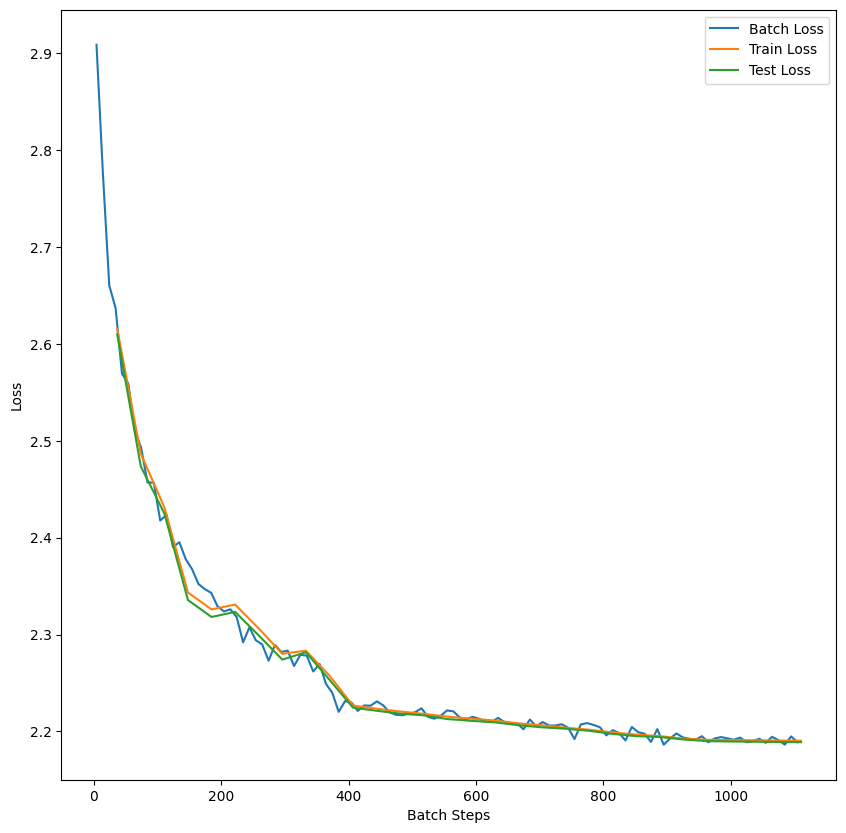

In [56]:
plot_stats(baseline_stats, batch_group=10)

Epoch 0 - Train Loss: 3.6512563228607178 - Test Loss: 3.683400869369507
Epoch 1 - Train Loss: 2.7892274856567383 - Test Loss: 2.7988505363464355
Epoch 2 - Train Loss: 2.605489730834961 - Test Loss: 2.624264717102051
Epoch 3 - Train Loss: 2.496173858642578 - Test Loss: 2.512035608291626
Epoch 4 - Train Loss: 2.4471418857574463 - Test Loss: 2.453949451446533
Epoch 5 - Train Loss: 2.4038186073303223 - Test Loss: 2.415601968765259
Epoch 6 - Train Loss: 2.3758909702301025 - Test Loss: 2.3903794288635254
Epoch 7 - Train Loss: 2.3315131664276123 - Test Loss: 2.3357725143432617
Epoch 8 - Train Loss: 2.322063446044922 - Test Loss: 2.3380556106567383
Epoch 9 - Train Loss: 2.292755126953125 - Test Loss: 2.3078582286834717
Epoch 0 - Train Loss: 2.1877524852752686 - Test Loss: 2.196342945098877
Epoch 1 - Train Loss: 2.187957286834717 - Test Loss: 2.1969492435455322
Epoch 2 - Train Loss: 2.1865904331207275 - Test Loss: 2.196594476699829
Epoch 3 - Train Loss: 2.186293601989746 - Test Loss: 2.19686555

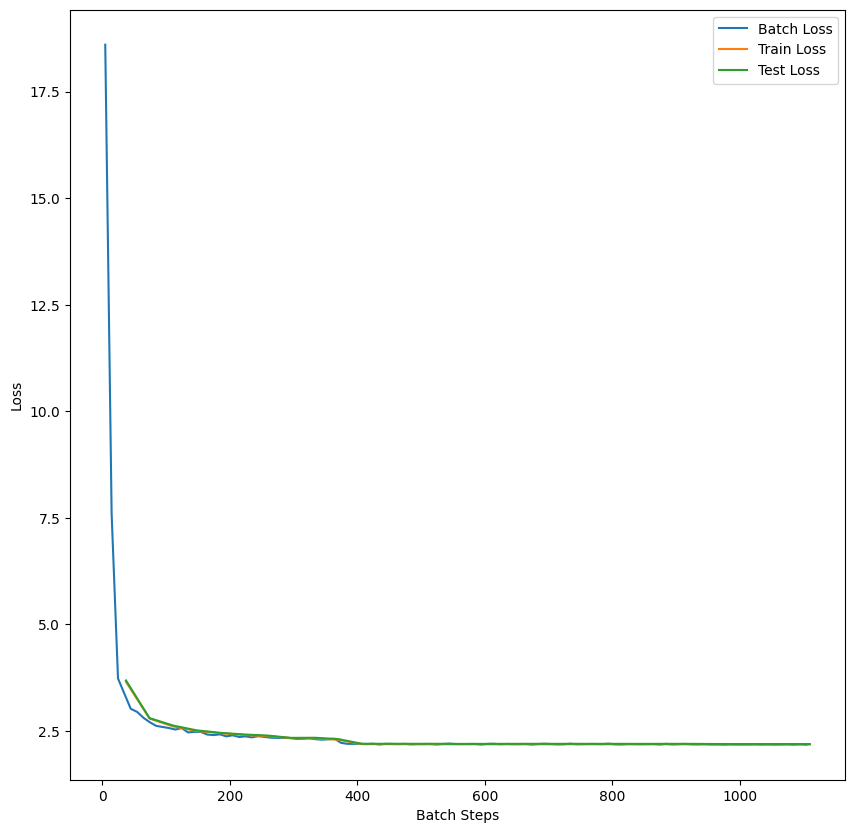

In [54]:
wavenet_stats = train_regimen(wavenet, [10, 15, 5], [5e-1, 1e-1, 1e-2], x=train_wX, y=train_wy, test_x=dev_wX, test_y=dev_wy)

In [57]:
for i in range(15):
    print(wavenet.sample_word())

devon
yannish
jaylee
bemry
maheilisash
sobonn
drowion
jionbel
kailena
soadie
kerselin
kianja
waydre
nelis
beblly
